# This is for data analysis of all things

In [85]:
import datetime

# Imports
import pandas as pd
import matplotlib.pyplot as plt
import folium
import numpy as np
import json
import math
import seaborn as sns

In [19]:
'''
Open data.
'''
# All measurement data
df_measurement_data = pd.read_csv('data/combined_measurements.csv', on_bad_lines='skip', low_memory=False)
#print(df_measurement_data.loc[df_measurement_data['prb_id'] == 'Ping'])
#df_measurement_data['prb_id'] = df_measurement_data['prb_id'].astype('int64')

# All the selected probes including their type and location
df_selected_probes = pd.read_csv('data/coordinates_continents_selected_probes.csv')
#df_selected_probes['prb_id'] = df_selected_probes['prb_id'].astype('int64')

# Selected probes joined with measured data
df_probes_measurement_joined = df_selected_probes.merge(df_measurement_data, how='inner', left_on='id', right_on='prb_id')

<Axes: xlabel='Technology'>

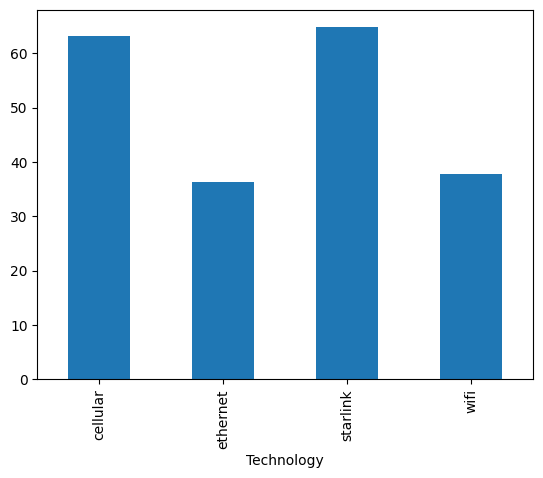

In [45]:
'''
Plot the average rtt for the different access technologies.
'''
# Replace -1 values with NaN
df_probes_measurement_joined.replace(-1, np.nan, inplace=True)
# Calculate average ignoring NaN values
df_probes_measurement_joined['average_rtt'] = df_probes_measurement_joined[['rtt1', 'rtt2', 'rtt3']].mean(axis=1)
df_probes_measurement_joined.groupby('type_x')['average_rtt'].mean().plot(kind='bar', xlabel='Technology')

/var/folders/1l/bh3yv7897j3chh18vpc221k40000gp/T/ipykernel_82277/2142053695.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_probes_measurement_joined['datetime'] = pd.to_datetime(df_probes_measurement_joined['timestamp'], unit='s')


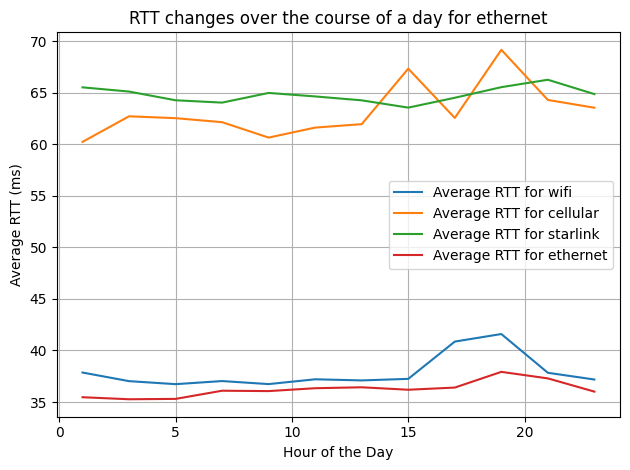

In [50]:
'''
Plot the rtt over the course of a day for each access technology.
'''

# Replace -1 values with NaN
df_probes_measurement_joined.replace(-1, np.nan, inplace=True)

# Calculate average ignoring NaN values
df_probes_measurement_joined['average_rtt'] = df_probes_measurement_joined[['rtt1', 'rtt2', 'rtt3']].mean(axis=1)

# Convert the timestamp to datetime and append to df
df_probes_measurement_joined['datetime'] = pd.to_datetime(df_probes_measurement_joined['timestamp'], unit='s')

# Extracting the hour of the day
df_probes_measurement_joined['hour'] = df_probes_measurement_joined['datetime'].dt.hour

technologies = df_probes_measurement_joined['type_x'].unique()

# Plot the RTT changes for each technology
fig, axs = plt.subplots(1, 1)

for i, tech in enumerate(technologies):
    # Filter the DataFrame by technology
    df_tech = df_probes_measurement_joined[df_probes_measurement_joined['type_x'] == tech]
    
    # Group by hour and calculate the average RTT
    avg_rtt_by_hour = df_tech.groupby('hour')['average_rtt'].mean()
    
    axs.plot(avg_rtt_by_hour.index, avg_rtt_by_hour.values, label=f'Average RTT for {tech}')
    axs.set_title(f'RTT changes over the course of a day for {tech}')
    axs.set_xlabel('Hour of the Day')
    axs.set_ylabel('Average RTT (ms)')
    axs.legend()
    axs.grid(True)

plt.tight_layout()
plt.show()


/var/folders/1l/bh3yv7897j3chh18vpc221k40000gp/T/ipykernel_82277/4203028070.py:11: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_probes_measurement_joined['datetime'] = pd.to_datetime(df_probes_measurement_joined['timestamp'], unit='s')


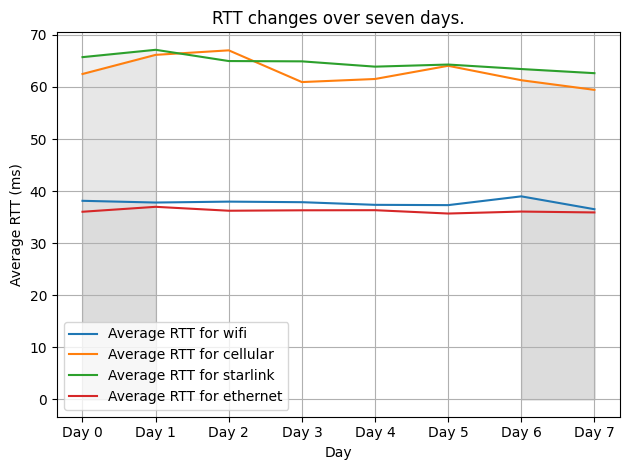

In [47]:
'''
Plot the rtt over the course of a day for each access technology.
'''
# Replace -1 values with NaN
df_probes_measurement_joined.replace(-1, np.nan, inplace=True)

# Calculate average ignoring NaN values
df_probes_measurement_joined['average_rtt'] = df_probes_measurement_joined[['rtt1', 'rtt2', 'rtt3']].mean(axis=1)

# Convert the timestamp to datetime and append to df
df_probes_measurement_joined['datetime'] = pd.to_datetime(df_probes_measurement_joined['timestamp'], unit='s')

# Extracting the day of the week
df_probes_measurement_joined['day_of_week'] = df_probes_measurement_joined['datetime'].dt.dayofweek

# Extracting the day of the year
df_probes_measurement_joined['day'] = df_probes_measurement_joined['datetime'].dt.dayofyear

technologies = df_probes_measurement_joined['type_x'].unique()

# Plot the RTT changes for each technology
fig, axs = plt.subplots(1, 1)

for i, tech in enumerate(technologies):
    # Filter the DataFrame by technology
    df_tech = df_probes_measurement_joined[df_probes_measurement_joined['type_x'] == tech]
    
    # Group by day and calculate the average RTT
    avg_rtt_by_day = df_tech.groupby('day')['average_rtt'].mean()
    
    # Color weekends differently
    weekend_color = 'lightgray'
    colors = ['blue' if df_tech['day_of_week'].iloc[0] < 5 else weekend_color for _ in range(len(avg_rtt_by_day))]
    
    axs.plot(avg_rtt_by_day.index, avg_rtt_by_day.values, label=f'Average RTT for {tech}')
    
    # Find weekend days and fill the corresponding areas
    weekend_indices = df_tech[df_tech['day_of_week'] >= 5]['day'].unique()
    for weekend_index in weekend_indices:
        weekend_start = avg_rtt_by_day.index.get_loc(weekend_index)
        if weekend_start > 0:
            axs.fill_between(avg_rtt_by_day.index[weekend_start - 1:weekend_start + 1],
                             avg_rtt_by_day.values[weekend_start - 1:weekend_start + 1],
                             color=weekend_color, alpha=0.3)
    
    axs.set_title(f'RTT changes over seven days.')
    axs.set_xlabel('Day')
    axs.set_ylabel('Average RTT (ms)')
    axs.legend()
    axs.grid(True)

# Set x-axis ticks as "Day 0", "Day 1", "Day 2", etc.
day_labels = [f'Day {i}' for i in range(len(avg_rtt_by_day))]
axs.set_xticks(avg_rtt_by_day.index)
axs.set_xticklabels(day_labels)

plt.tight_layout()
plt.show()


In [90]:
'''
Get all the probes which are in the probe to datacenter mapping but did not appear in the measured data.
'''

# Left join
non_matching_probes = df_selected_probes.merge(df_probes_measurement_joined[['prb_id']], how='left', left_on='id', right_on='prb_id', indicator=True).loc[lambda x: x['_merge'] == 'left_only']

# Drop the columns that came from df_probes_measurement_joined and the _merge column
print("Probes without measurements:")
useless_probes = non_matching_probes.drop(columns=['prb_id', '_merge'])
print(useless_probes)

print("Number of probes not actually measuring by type:")
print(useless_probes.groupby(['type'])['type'].count())


Probes without measurements:
        Unnamed: 0       id      type  latitude  longitude      continent  \
0                0  1006833      wifi   10.1385    76.4585           Asia   
6571             4  1002493      wifi   42.3085   -83.7185  North America   
12332           11    14680      wifi   53.3375    83.7715         Europe   
38296           26  1006934      wifi   48.2095    22.6385         Europe   
57376           36    29292      wifi   50.0185     8.3515         Europe   
88220           50    50612  cellular   47.3785     8.5375         Europe   
88221           51  1001185  cellular  -31.9505   115.8515        Oceania   
92252           54    32473  cellular   49.9485    82.6305           Asia   
92253           55      863  cellular  -34.9215   -56.1595  South America   
92614           57    27989  cellular  -33.8985   150.8915        Oceania   
92615           58    35507  cellular   -6.4895   106.7875           Asia   
92616           59    20948  cellular   29.3815

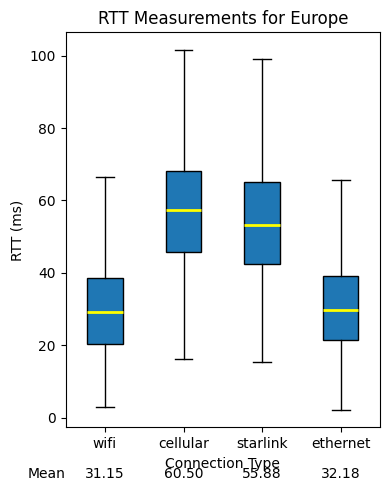

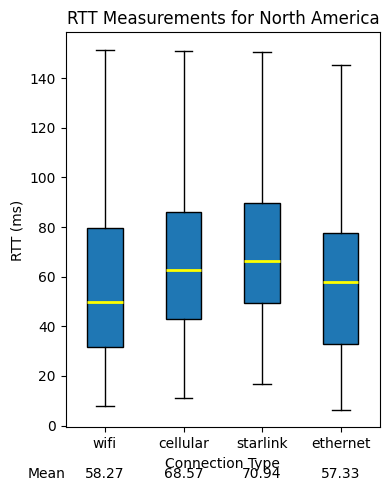

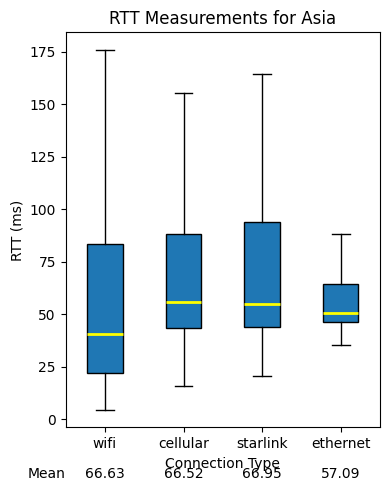

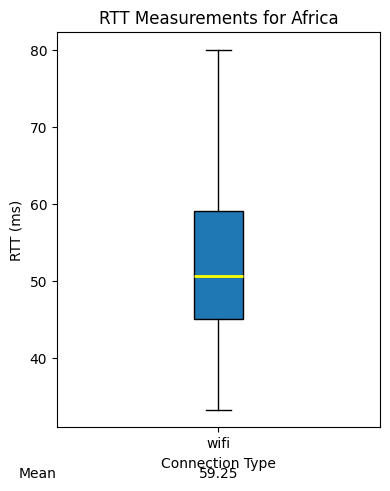

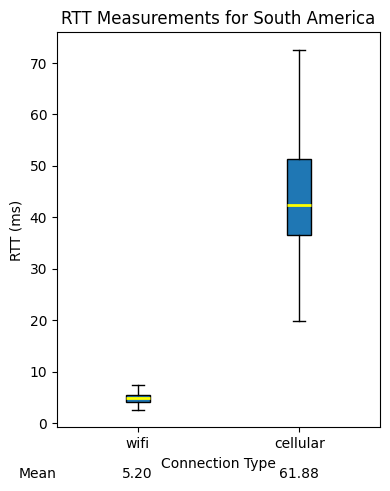

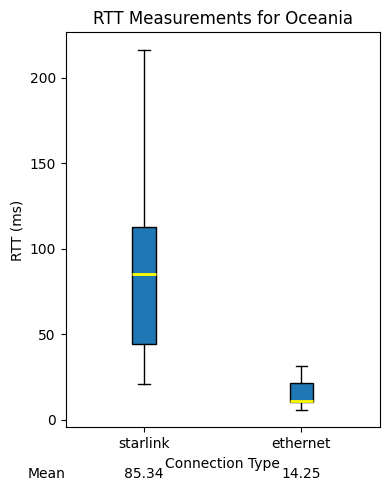

In [88]:
'''
Last mile technology split up by continent
'''

df_probes_measurement_joined.replace(-1, np.nan, inplace=True)
df = df_probes_measurement_joined
continents = df['continent'].unique()

def create_boxplot_for_continent(continent):
    df_filtered = df[df['continent'] == continent]
    mean_rtts = []
    types = df_filtered['type_x'].unique()
    
    data_to_plot = []
    labels = []  
    means = []
    for type_x in types:
        rtt_values = df_filtered[df_filtered['type_x'] == type_x][['rtt1', 'rtt2', 'rtt3']].values.flatten().tolist()
        
        clean_values = [x for x in rtt_values if not math.isnan(x) and not math.isinf(x)]
        # Only add to plot if there are values
        if clean_values:
            data_to_plot.append(clean_values)
            labels.append(type_x)
            means.append(np.mean(clean_values))  # Storing the mean
            mean_rtts.append((type_x, pd.Series(clean_values).mean()))
        else:
            print("oh no", continent, type_x)
    
    fig, ax = plt.subplots(figsize=(4, 5))
    bplot = ax.boxplot(data_to_plot, labels=labels, patch_artist=True, medianprops=dict(linestyle='-', linewidth=2, color='yellow'), showfliers=False)
    
    ax.set_title(f'RTT Measurements for {continent}')
    ax.set_xlabel('Connection Type')
    ax.set_ylabel('RTT (ms)')
    
    # Adjusting y position below the x-axis for annotations
    y_position = ax.get_ylim()[0] - ((ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.1)  # Adjust this factor as necessary
    
    # Annotating each box with its mean RTT value under its label
    for i, mean in enumerate(means, start=1):
        # Placing text annotations just below the x-axis labels, inside the plot area
        ax.text(i, y_position, f'{mean:.2f}', ha='center', va='top')  # Horizontal alignment is centered; vertical alignment at the top of the text
    
    ax.text(0, y_position, 'Mean', ha='right', va='top', transform=ax.get_yaxis_transform())

    plt.tight_layout()
    plt.show()    
# Iterate over each continent to create a boxplot for each
for continent in continents:
    create_boxplot_for_continent(continent)



In [76]:
'''
Show stability of the technologies.
'''
df_probes_measurement_joined.replace(-1, np.nan, inplace=True)

# Load the JSON string into a DataFrame
with open('data/20240206.json', 'r') as file:
    data = json.load(file)

# Extract the list of objects from the 'objects' key
objects_list = data['objects']

# Create a DataFrame from the list of objects
da = pd.DataFrame(objects_list)

da = da.merge(df_probes_measurement_joined, how='inner', on='id')

df = da
types = df['type_x'].unique()
types = types[types != "ethernet"]

df['rtt_diff1'] = abs(df['rtt2'] - df['rtt1'])
df['rtt_diff2'] = abs(df['rtt3'] - df['rtt2'])

# Calculate average jitter for each row
df['jitter'] = (df['rtt_diff1'] + df['rtt_diff2']) / 2
df['packet_loss_percentage'] = (1 - (df['rcvd'] / df['sent'])) * 100

df['packet_loss_percentage'] = df['packet_loss_percentage'].fillna(0).replace([float('inf'), -float('inf')], 0)
aggregated_data = []

In [82]:
def get_values_from_prov(da, prov_name, vers):
    da_filtered = da[da[f'asn_v{vers}'] == prov_name]
    values_by_type = []
    for type_x in types:
        # Filtering the dataframe for the current type
        df_filtered = da_filtered[da_filtered['type_x'] == type_x]
        
        # Flattening RTT and jitter values
        rtt_values = df_filtered[['rtt1', 'rtt2', 'rtt3']].values.flatten()
        jitter_values = df_filtered['jitter'].values.flatten()
        loss_values = df_filtered['packet_loss_percentage'].values.flatten()
        # Cleaning the data by removing NaNs and Infs
        clean_rtt = [x for x in rtt_values if not np.isnan(x) and not np.isinf(x)]
        clean_jitter = [x for x in jitter_values if not np.isnan(x) and not np.isinf(x)]
        clean_loss = [x for x in loss_values if not np.isnan(x) and not np.isinf(x)]
    
        # Calculating mean jitter and variance of RTT for the current type
        mean_jitter = np.mean(clean_jitter) if len(clean_jitter) > 0 else np.nan
        rtt_variance = np.var(clean_rtt) if len(clean_rtt) > 0 else np.nan
        mean_loss = np.mean(clean_loss) if len(clean_loss) > 0 else np.nan
        
        values_by_type.append({type_x: [mean_jitter, rtt_variance, mean_loss]})
    return values_by_type

In [83]:
types = df_probes_measurement_joined['type_x'].unique()
types = types[types != "ethernet"]

results = []

for type_x in types:
    # Filtering the dataframe for the current type
    df_filtered = da[da['type_x'] == type_x]
    
    # Flattening RTT and jitter values
    rtt_values = df_filtered[['rtt1', 'rtt2', 'rtt3']].values.flatten()
    jitter_values = df_filtered['jitter'].values.flatten()
    loss_values = df_filtered['packet_loss_percentage'].values.flatten()
    
    # Cleaning the data by removing NaNs and Infs
    clean_rtt = rtt_values[~np.isnan(rtt_values) & ~np.isinf(rtt_values)]
    clean_jitter = jitter_values[~np.isnan(jitter_values) & ~np.isinf(jitter_values)]
    clean_loss = loss_values[~np.isnan(loss_values) & ~np.isinf(loss_values)]

    # Calculating mean jitter and variance of RTT for the current type
    mean_jitter = np.mean(clean_jitter) if len(clean_jitter) > 0 else np.nan
    rtt_variance = np.var(clean_rtt) if len(clean_rtt) > 0 else np.nan
    mean_loss = np.mean(clean_loss) if len(clean_loss) > 0 else np.nan

    results.append([type_x, mean_jitter, rtt_variance, mean_loss])

# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['Type', 'Mean Jitter', 'RTT Variance', 'Mean Loss'])
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: green' if v else '' for v in is_min]

# Apply styles to the DataFrame
styled_df = df_results.style.apply(highlight_min, subset=['Mean Jitter', 'RTT Variance', 'Mean Loss'])
# Display the DataFrame
styled_df = styled_df.set_table_styles([{'selector': 'table', 'props': [('display', 'none')]}])

styled_df

,Type,Mean Jitter,RTT Variance,Mean Loss
0,wifi,3.133420,1148.081287,0.959398
1,cellular,9.892838,1718.283583,0.871265
2,starlink,8.084145,754.674734,0.557438


In [84]:
'''
More statistics on stability.
'''
vers = 6
providers = da[f'asn_v{vers}'].unique()
data_dict = {}
metrics = ["Mean Jitter", "RTT Variance", "Mean Loss"]

for provider in providers:
    flattened_data = {}
        
    provider_data = get_values_from_prov(da, provider, vers)
    for item in provider_data:
        tech, values = list(item.items())[0]
        for i, val in enumerate(values):
            key = f"{tech} - {metrics[i]}"
            flattened_data[key] = val
    
    data_dict[provider] = flattened_data

df = pd.DataFrame.from_dict(data_dict, orient='index')

df

,wifi - Mean Jitter,wifi - RTT Variance,wifi - Mean Loss,cellular - Mean Jitter,cellular - RTT Variance,cellular - Mean Loss,starlink - Mean Jitter,starlink - RTT Variance,starlink - Mean Loss
20001.0,28.912082,3660.666292,0.260738,NaN,NaN,NaN,NaN,NaN,NaN
3209.0,NaN,NaN,NaN,16.230435,450.398786,0.138889,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12322.0,0.949563,124.919947,0.000000,NaN,NaN,NaN,5.801508,259.396794,0.163035
33915.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13188.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7922.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2860.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24560.0,0.867312,106.678686,1.111111,NaN,NaN,NaN,NaN,NaN,NaN
12392.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
